In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.optimizers import AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

In [2]:
from data.lorenz import solve_lorenz

lorenz_sol = solve_lorenz(initial_state=jnp.array([ 0.37719066, -0.39631459, 16.92126795]))
dt = 0.05
t_train = jnp.arange(0,10.01,dt)

true_sigma2 = 0.05
x_vals = jax.vmap(lorenz_sol.evaluate)(t_train)
x_train = x_vals + (
    jnp.sqrt(true_sigma2) * 
    jax.random.normal(jax.random.PRNGKey(32),(len(t_train),3))
)

measurement_vecs = jnp.tile(jnp.eye(3),(int(len(t_train)/3+1),1))[:len(t_train)]
y_obs = jnp.sum(measurement_vecs*x_train,axis=1)

In [3]:
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
noise_var = 4.
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=0.2,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)


In [4]:
n_colloc = 500
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 100. * n_colloc
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 0.1)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )

In [5]:
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y','z']
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    t_train,
    t_colloc = None,
    w_colloc = None,
    partialobs_v = measurement_vecs,
    partialobs_y = y_obs,
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.00938403e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50000.0}
Solving for data_weight = 1.0, colloc_weight = 400.0 beta_reg = 0.008


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 7.219e+03, gradnorm = 1.403e+05, alpha = 4.167, improvement_ratio = 0.9458
Iteration 1, loss = 1.96e+03, gradnorm = 4.234e+05, alpha = 4.167, improvement_ratio = 0.7365
Iteration 2, loss = 425.1, gradnorm = 3.593e+05, alpha = 3.472, improvement_ratio = 0.8063
Iteration 3, loss = 111.3, gradnorm = 1.278e+05, alpha = 2.894, improvement_ratio = 0.8145
Iteration 4, loss = 44.31, gradnorm = 7.285e+04, alpha = 2.411, improvement_ratio = 0.8113
Iteration 5, loss = 24.83, gradnorm = 2.304e+04, alpha = 2.009, improvement_ratio = 0.9411
Line Search Failed!
Final Iteration Results
Iteration 67, loss = 4.093, gradnorm = 4.438e-06, alpha = 1.819e+04, improvement_ratio = -inf
Solving for data_weight = 1.0, colloc_weight = 2000.0 beta_reg = 0.004


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 4.111, gradnorm = 84.59, alpha = 4.167, improvement_ratio = 0.9999
Iteration 1, loss = 4.111, gradnorm = 19.75, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 4.111, gradnorm = 0.726, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 4.111, gradnorm = 0.4202, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 4.111, gradnorm = 0.2472, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 4.111, gradnorm = 0.179, alpha = 1.674, improvement_ratio = 1.0
Iteration 69, loss = 4.11, gradnorm = 3.832e-05, alpha = 281.2, improvement_ratio = 1.535e+03
Solving for data_weight = 1.0, colloc_weight = 10000.0 beta_reg = 0.002


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 4.115, gradnorm = 85.02, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 4.115, gradnorm = 9.824, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 4.115, gradnorm = 0.5748, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 4.115, gradnorm = 0.2499, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 4.115, gradnorm = 0.129, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 4.115, gradnorm = 0.09605, alpha = 1.674, improvement_ratio = 1.0
Line Search Failed!
Final Iteration Results
Iteration 53, loss = 4.114, gradnorm = 2.81e-05, alpha = 6.075e+03, improvement_ratio = -inf
Solving for data_weight = 1.0, colloc_weight = 50000.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 4.115, gradnorm = 85.14, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 4.115, gradnorm = 2.599, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 4.115, gradnorm = 0.1896, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 4.115, gradnorm = 0.06744, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 4.115, gradnorm = 0.03425, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 4.115, gradnorm = 0.02578, alpha = 1.674, improvement_ratio = 1.0
Line Search Failed!
Final Iteration Results
Iteration 45, loss = 4.115, gradnorm = 0.0007076, alpha = 19.55, improvement_ratio = -4.848e+03
Model after smooth warm start
(x)' = 5.239 1 + -9.101 x + 9.564 y + -0.560 z + -0.083 x^2 + 0.099 x y + -0.022 x z + -0.028 y^2 + 0.010 y z + 0.016 z^2
(y)' = -0.462 1 + 27.901 x + -0.785 y + -0.033 z + 0.030 x^2 + -0.045 x y + -0.997 x z + 0.014 y^2 + -0.007 y z + 0.001 z^2
(z)' = 1.968 1 + -0.115 x + -0.058 y + -2.913 z + -0.055 x^2 + 1.035 x y 

In [9]:
model.print()

(x)' = -9.964 x + 10.040 y
(y)' = 27.917 x + -1.015 y + -0.997 x z
(z)' = -2.658 z + 0.999 x y


In [10]:
print(model.traj_model.kernel)

192.082 + 71.08Matern(5,0.15)


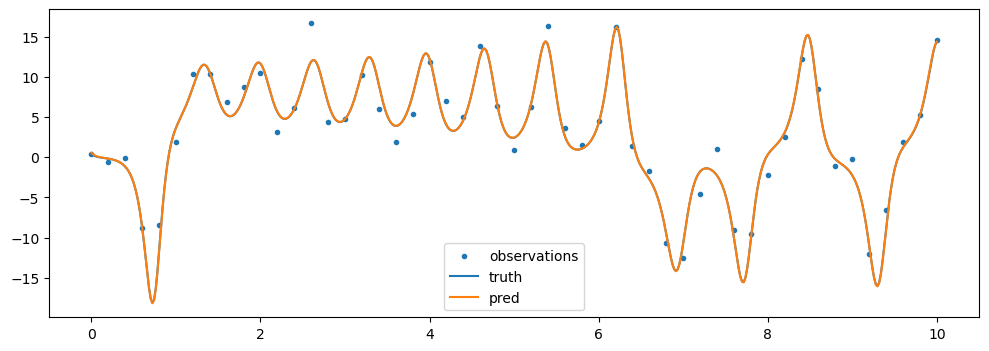

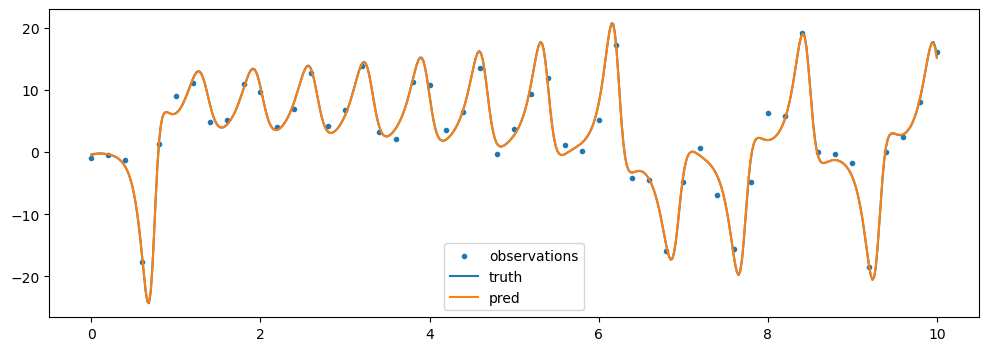

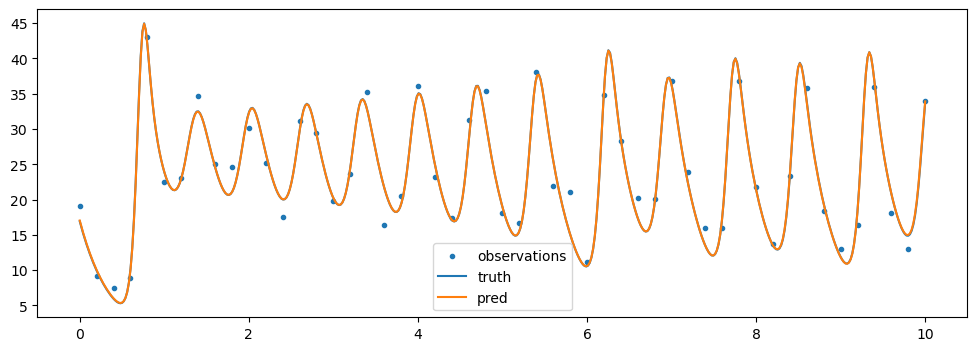

In [11]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
for dim in range(3):
    plt.figure(figsize=(12,4))
    plt.scatter(expdata.t_train,expdata.x_train[:,dim],label = 'observations',s = 9)
    plt.plot(t_grid,true_states[:,dim],label = 'truth')
    plt.plot(t_grid,state_preds[:,dim],label = 'pred')
    plt.legend()
    plt.show()
